In [ ]:
!pip install -U fastai gradio torchvision
from fastai.vision.all import *
import torchvision.datasets as datasets
import os

Dataset size: 27000
Number of classes: 10
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


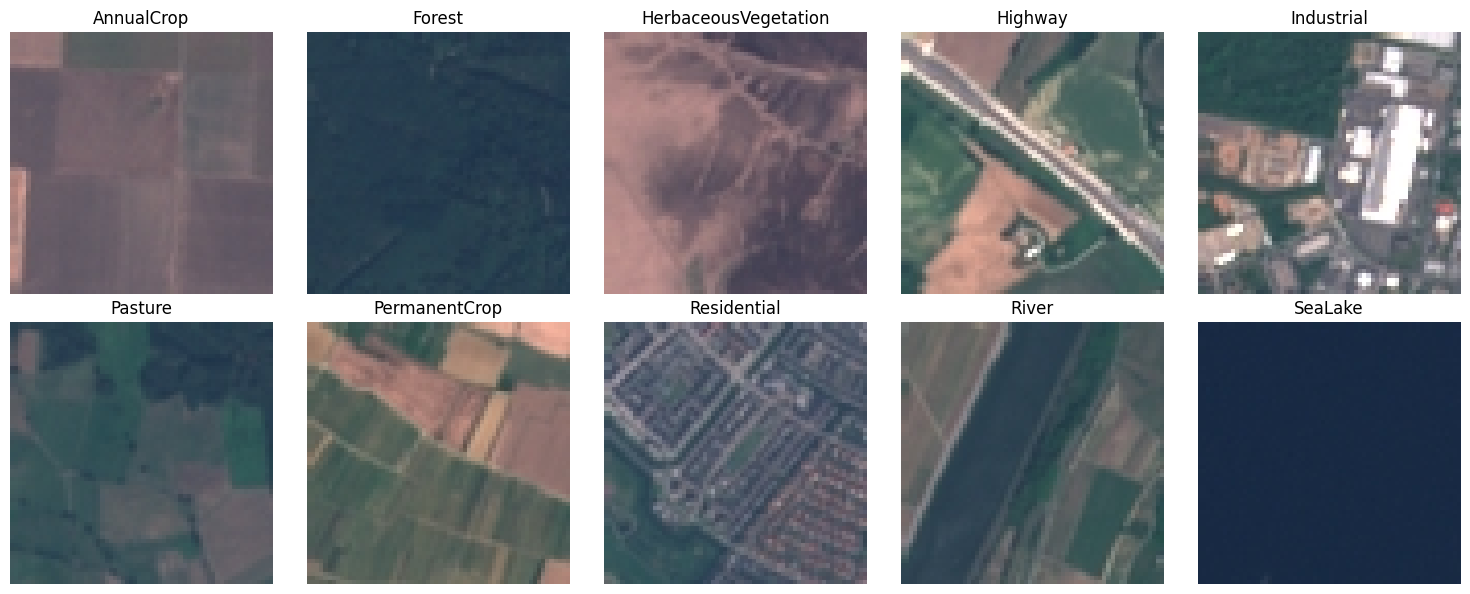

In [9]:
base_path = "/content/eurosat"
os.makedirs(base_path, exist_ok=True)

dataset = datasets.EuroSAT(root=base_path, download=True, transform=None)

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

class_samples = {}
for i in range(len(dataset)):
    img, label = dataset[i]
    if label not in class_samples:
        class_samples[label] = i
    if len(class_samples) == 10:
        break

for i, (label, sample_idx) in enumerate(class_samples.items()):
    row = i // 5
    col = i % 5
    img, _ = dataset[sample_idx]
    axes[row, col].imshow(img)
    axes[row, col].set_title(dataset.classes[label])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Training samples: 21600
Validation samples: 5400
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


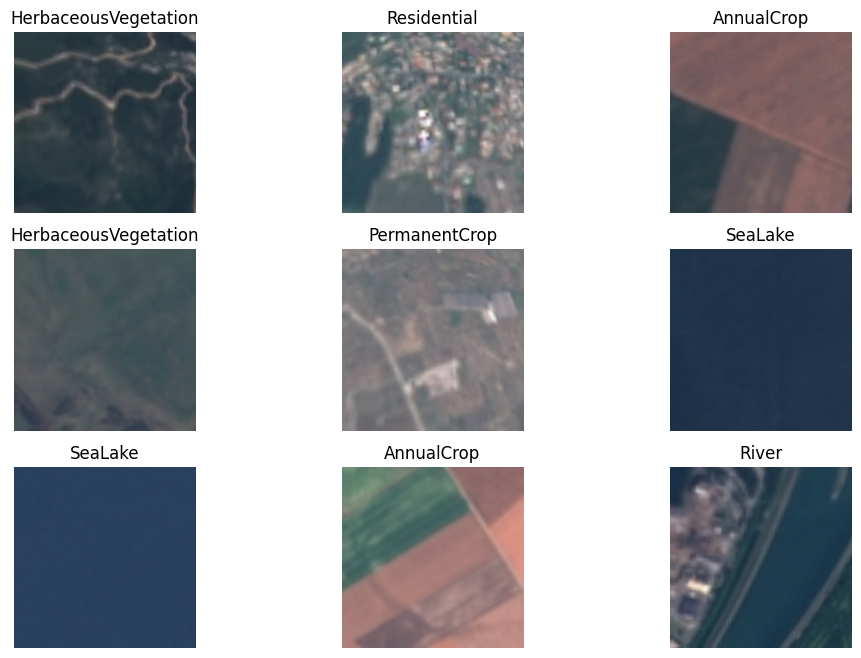

In [10]:
def get_label(f): return f.parent.name

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42, valid_pct=0.2),
    get_y=get_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(base_path, bs=32)
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")
print(f"Classes: {dls.vocab}")

dls.show_batch(max_n=9, figsize=(12, 8))

In [11]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.460474,0.277572,0.910370,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.256622,0.103958,0.961481,00:47
1,0.202614,0.117471,0.963704,00:47
2,0.149881,0.067259,0.976296,00:47
3,0.079323,0.045677,0.983333,00:47
4,0.064002,0.045686,0.985370,00:47


[('AnnualCrop', 'PermanentCrop', np.int64(14)),
 ('Industrial', 'Residential', np.int64(9)),
 ('HerbaceousVegetation', 'PermanentCrop', np.int64(8)),
 ('Pasture', 'HerbaceousVegetation', np.int64(6)),
 ('River', 'Highway', np.int64(6))]

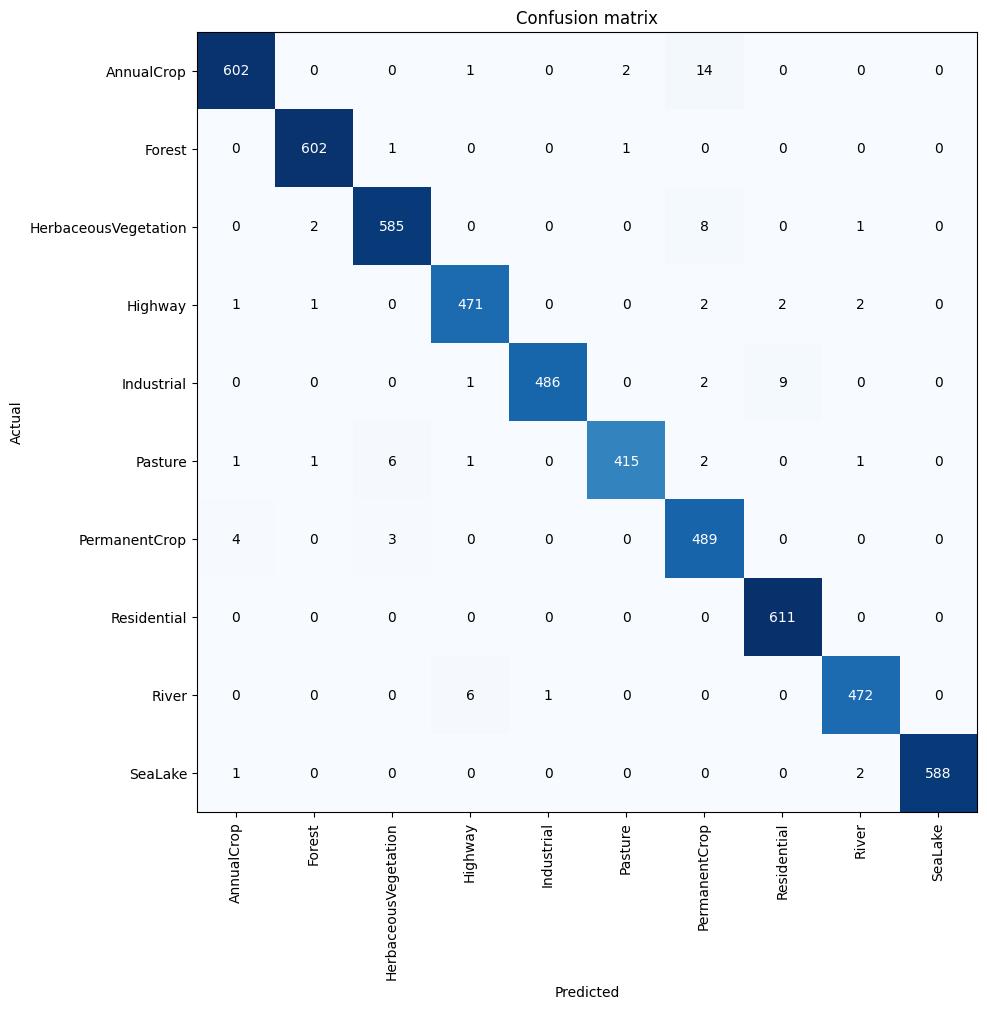

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))
interp.most_confused(min_val=5)

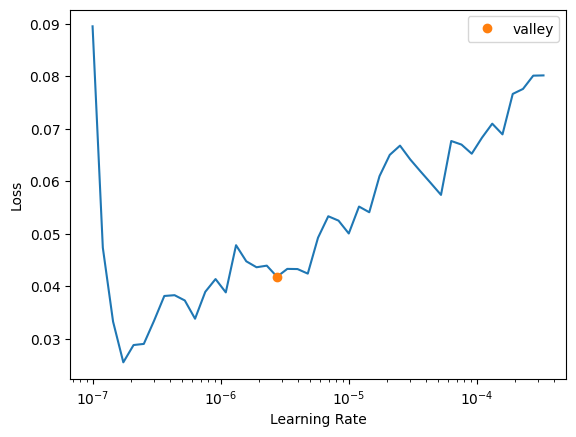

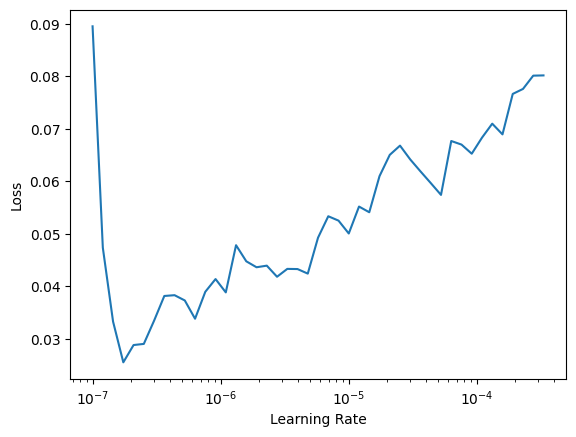

In [18]:
learn.lr_find()
learn.recorder.plot_lr_find(suggestion=True)

In [19]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-6, 3e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.045878,0.045205,0.984074,00:47
1,0.060932,0.042489,0.985185,00:47
2,0.056798,0.040394,0.986296,00:47
3,0.045733,0.041753,0.986481,00:47
4,0.054379,0.038528,0.986852,00:47


Final accuracy: 0.9869



Most confused classes:


AnnualCrop -> PermanentCrop: 11 times
HerbaceousVegetation -> PermanentCrop: 9 times
Industrial -> Residential: 7 times
Pasture -> HerbaceousVegetation: 4 times
PermanentCrop -> AnnualCrop: 4 times
River -> Highway: 4 times
HerbaceousVegetation -> Forest: 3 times
PermanentCrop -> HerbaceousVegetation: 3 times


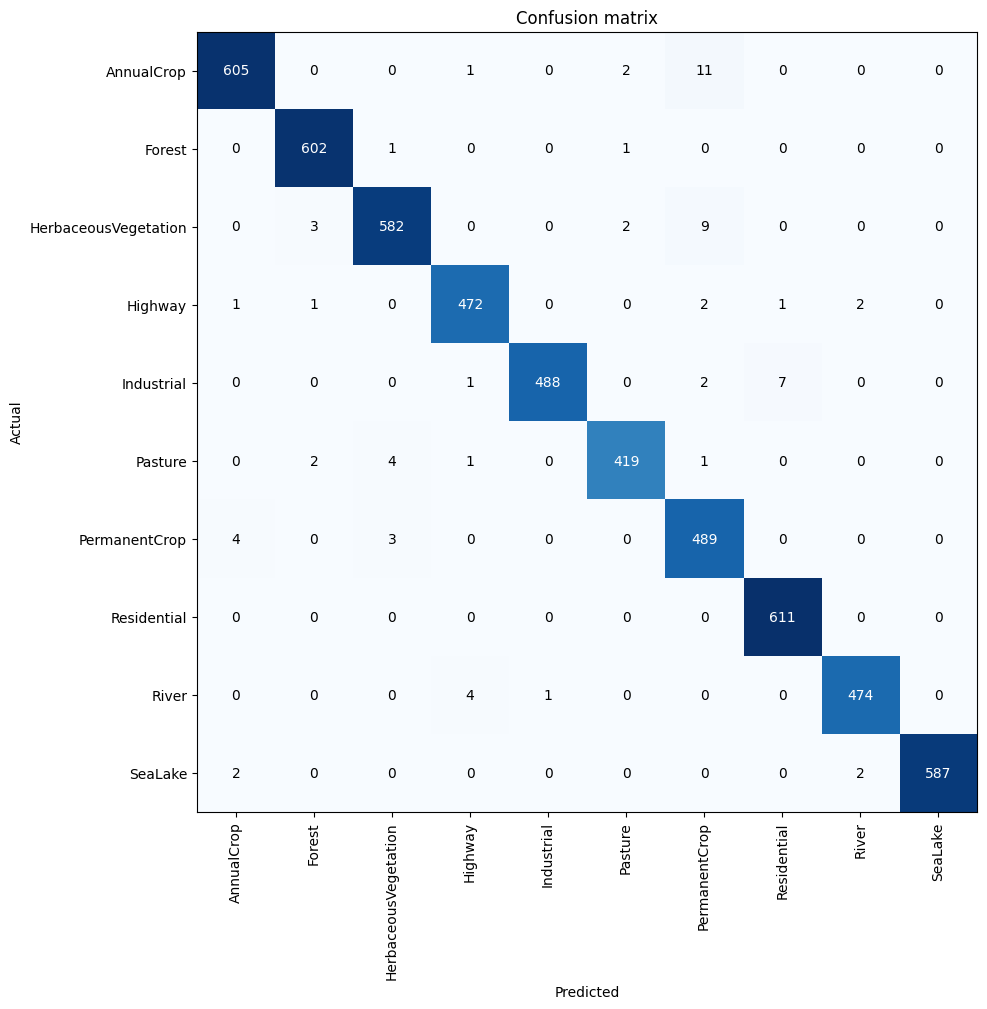

In [24]:
preds, targs = learn.get_preds()
acc = accuracy(preds, targs)
print(f"Final accuracy: {acc.item():.4f}")

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(10, 10))

print("\nMost confused classes:")
for item in interp.most_confused(min_val=3):
    print(f"{item[0]} -> {item[1]}: {item[2]} times")

In [25]:
learn.export('export.pkl')
from google.colab import files
files.download('export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>